<a href="https://colab.research.google.com/github/Yuliana1453/Klasifikasi-Gambar/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Fruits-360](https://www.kaggle.com/datasets/moltean/fruits)
- **Nama:** Yuliana
- **Email:** yulianayuls24@gmail.com
- **ID Dicoding:** MC224D5X1784

## Import Semua Packages/Library yang Digunakan

In [2]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import os
import tensorflow as tf
from google.colab import files
from PIL import Image

In [3]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

In [8]:
# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d moltean/fruits

# Unzip file
!unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_277.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_281.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_285.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_289.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_29.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_33.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_37.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_41.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_45.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_49.j

### Data Preprocessing

#### Split Dataset

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Lokasi dataset
train_dir = '/content/fruits-360_100x100/fruits-360/Training'
test_dir = '/content/fruits-360_100x100/fruits-360/Test'

# Generator training + validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% val
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),       # Ukuran gambar
    batch_size=32,
    class_mode='categorical',     # Untuk klasifikasi multi-kelas
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test generator (tanpa augmentasi, hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 82296 images belonging to 201 classes.
Found 20494 images belonging to 201 classes.
Found 34314 images belonging to 201 classes.


In [10]:
print("Jumlah kelas:", len(train_generator.class_indices))
print("Nama kelas:", train_generator.class_indices.keys())

Jumlah kelas: 201
Nama kelas: dict_keys(['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cheri

## Modelling

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(201, activation='softmax')  # 201 kelas
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 201)            │       103,113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,750,473 (25.75 MB)

 Trainable params: 6,750,473 (25.75 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1920s 745ms/step - accuracy: 0.4460 - loss: 2.2839 - val_accuracy: 0.8968 - val_loss: 0.3392
Epoch 2/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1937s 744ms/step - accuracy: 0.8994 - loss: 0.2984 - val_accuracy: 0.9188 - val_loss: 0.2552
Epoch 3/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1823s 709ms/step - accuracy: 0.9310 - loss: 0.2065 - val_accuracy: 0.9066 - val_loss: 0.3201
Epoch 4/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1874s 728ms/step - accuracy: 0.9426 - loss: 0.1742 - val_accuracy: 0.9407 - val_loss: 0.2204
Epoch 5/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1877s 730ms/step - accuracy: 0.9535 - loss: 0.1386 - val_accuracy: 0.9481 - val_loss: 0.1837
Epoch 6/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1819s 707ms/step - accuracy: 0.9583 - loss: 0.1244 - val_accuracy: 0.9508 - val_loss: 0.2044
Epoch 7/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1837s 714ms/step - accuracy: 0.9648 - loss: 0.1065 - val_accuracy: 0.9388 - val_loss: 0.2628
Epoch 8/15
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 1824s 709ms/s

## Evaluasi dan Visualisasi

In [15]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

1073/1073 ━━━━━━━━━━━━━━━━━━━━ 184s 171ms/step - accuracy: 0.9760 - loss: 0.1379
Test Accuracy: 97.94%
Test Loss: 0.1219


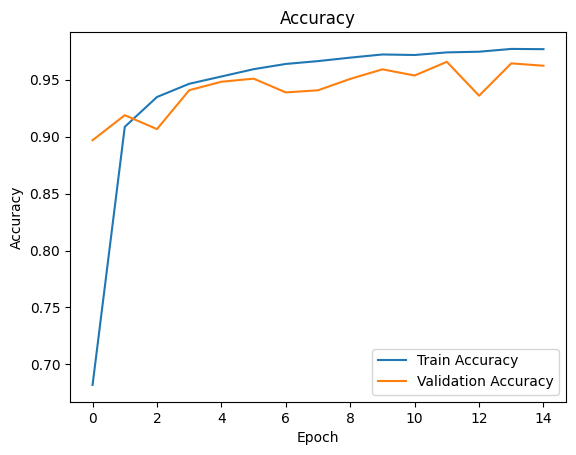

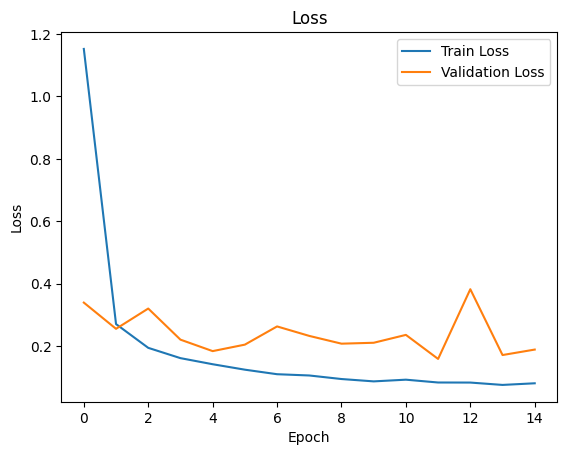

In [16]:
# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Insight:**

**📈 Akurasi**

- Train Accuracy meningkat secara signifikan dari ~70% ke hampir 97%.

- Validation Accuracy juga meningkat cepat dan stabil di kisaran 94–96%.

**Kesimpulan:** Model kamu belajar dengan sangat baik dan generalisasi ke data validasi juga sangat bagus.

**📉 Loss**
- Train Loss turun drastis dari >1.2 ke di bawah 0.05.

- Validation Loss awalnya turun, tapi kemudian sedikit naik-turun di kisaran 0.2-0.3.

**🔍 Insight Utama:**
✅ Model tidak overfitting parah meskipun train accuracy lebih tinggi daripada validasi — karena perbedaannya kecil.

⚠️ Dataset kurang seimbang (jumlah gambar antar kelas berbeda jauh)

💡 Solusi:

- Tambahkan augmentasi data,

- Coba EarlyStopping untuk mencegah overfitting ringan,

- Tambah/kurangi dropout, atau ubah struktur layer.



1073/1073 ━━━━━━━━━━━━━━━━━━━━ 220s 204ms/step
                           precision    recall  f1-score   support

                 Apple 10       1.00      0.96      0.98       231
                 Apple 11       1.00      1.00      1.00       142
                 Apple 12       1.00      1.00      1.00       154
                 Apple 13       1.00      1.00      1.00       235
                 Apple 14       1.00      1.00      1.00       154
                 Apple 17       1.00      1.00      1.00       201
                 Apple 18       1.00      1.00      1.00       160
                 Apple 19       0.97      1.00      0.98       241
                  Apple 5       1.00      1.00      1.00       146
                  Apple 6       0.89      1.00      0.94       157
                  Apple 7       1.00      1.00      1.00       229
                  Apple 8       0.96      0.93      0.94       228
                  Apple 9       0.92      1.00      0.96       231
         Apple

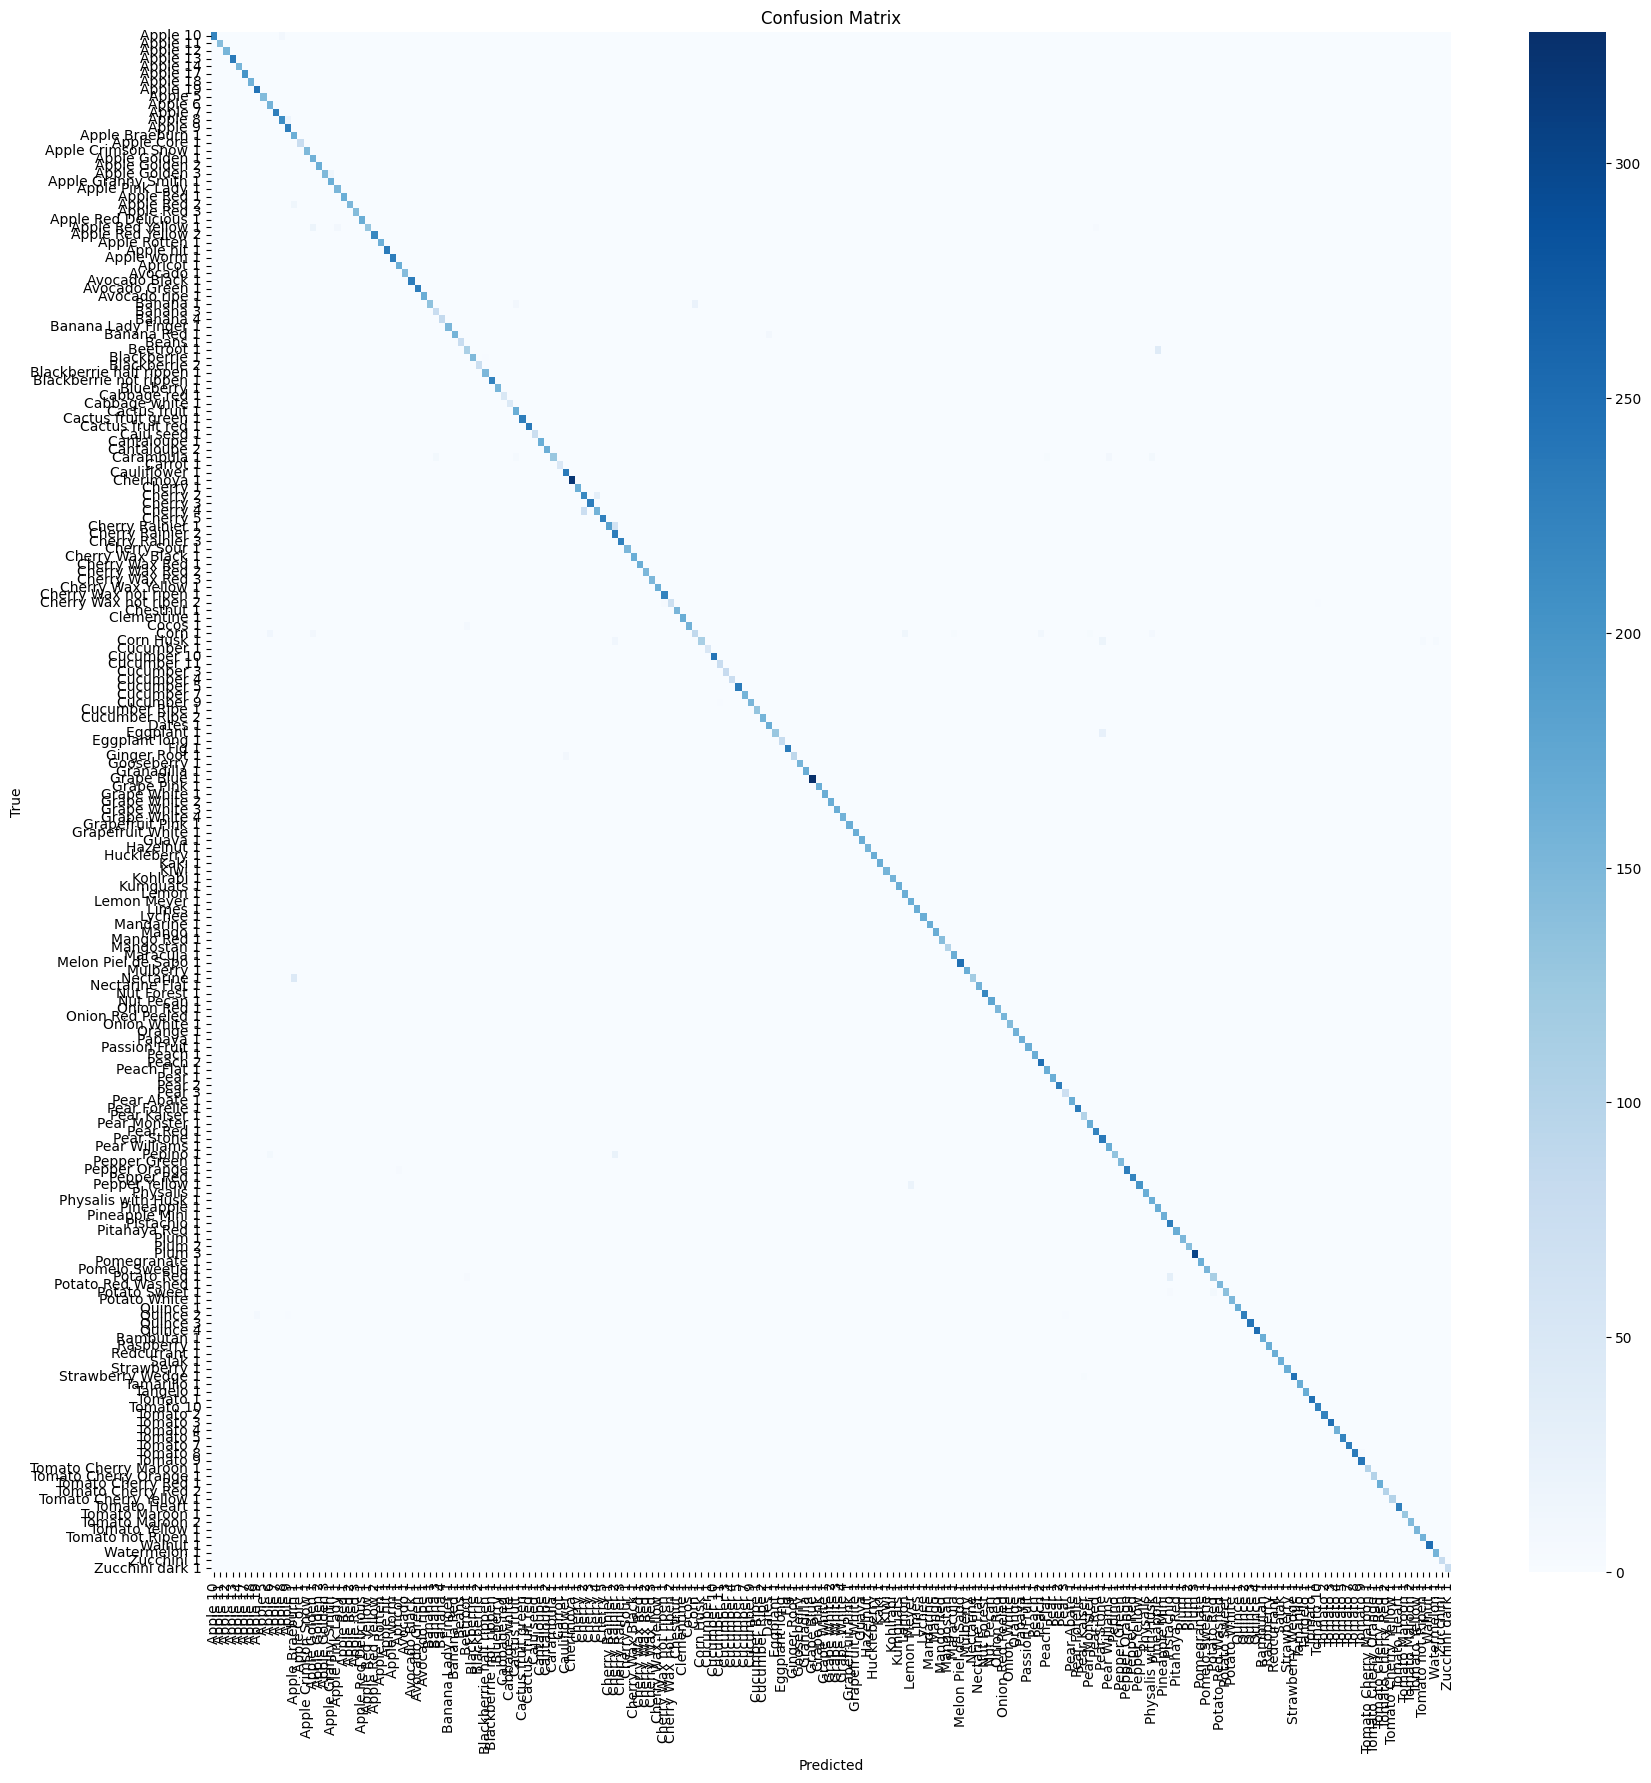

In [27]:
# Prediksi label
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Label sebenarnya
y_true = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Konversi Model

In [28]:
# --- [1] Pastikan folder struktur sudah dibuat ---
os.makedirs("submission/saved_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/tfjs_model", exist_ok=True)

# --- [2] Export ke format SavedModel ---
model.export("submission/saved_model")

# --- [3] Convert ke format TFLite ---
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()

# Simpan model .tflite
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# --- [4] Simpan Label ke label.txt ---
try:
    class_names = list(train_generator.class_indices.keys())
except:
    class_names = ['class1', 'class2', '...']
with open("submission/tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(f"{label}\n")

# --- [5] Convert ke format TensorFlow.js ---
!pip install tensorflowjs --quiet
import tensorflowjs as tfjs

# Simpan model ke folder TFJS
tfjs.converters.save_keras_model(model, "submission/tfjs_model")

print("✅ Semua format model berhasil diekspor!")


Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 201), dtype=tf.float32, name=None)
Captures:
  135540252185552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252186320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252185936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252189200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252188432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252190160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252189584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252190544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252190928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135540252192464: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file
✅ Semua format model berhasil diekspor!


## Inference (Optional)

In [33]:
# Upload gambar
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="submission/tflite/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Resize sesuai kebutuhan model
img = Image.open(filename).convert("RGB").resize((100, 100))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

# Prediksi
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]
predicted_class = np.argmax(output_data)

# Load label
with open("submission/tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f]

print(f"✅ Prediksi: {labels[predicted_class]} (Confidence: {output_data[predicted_class]:.2f})")


Saving Screenshot 2025-05-26 035226.png to Screenshot 2025-05-26 035226 (1).png
✅ Prediksi: Pear Red 1 (Confidence: 1.00)


In [35]:
requirements = """
tensorflow>=2.13
tensorflowjs
matplotlib
numpy
pandas
scikit-learn
opencv-python
seaborn
Pillow
"""

with open("requirements.txt", "w") as f:
    f.write(requirements.strip())

print("✅ File requirements.txt berhasil dibuat.")

✅ File requirements.txt berhasil dibuat.


In [36]:
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# Contoh: mengompres folder 'submission' jadi zip
!zip -r submission.zip /content/submission

# Baru download zip-nya
from google.colab import files
files.download("submission.zip")

  adding: content/submission/ (stored 0%)
  adding: content/submission/saved_model/ (stored 0%)
  adding: content/submission/saved_model/.ipynb_checkpoints/ (stored 0%)
  adding: content/submission/saved_model/variables/ (stored 0%)
  adding: content/submission/saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/submission/saved_model/variables/variables.index (deflated 62%)
  adding: content/submission/saved_model/saved_model.pb (deflated 85%)
  adding: content/submission/saved_model/assets/ (stored 0%)
  adding: content/submission/saved_model/fingerprint.pb (stored 0%)
  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/group1-shard2of7.bin (deflated 6%)
  adding: content/submission/tfjs_model/group1-shard7of7.bin (deflated 6%)
  adding: content/submission/tfjs_model/group1-shard5of7.bin (deflated 6%)
  adding: content/submission/tfjs_model/group1-shard1of7.bin (deflated 6%)
  adding: content/submission/tfjs_mod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>